In [9]:
from LSSTFringe import Sky_rubin as Sky  
from LSSTFringe import utils,plot_utils
import rubin_sim.utils.ObservationMetaData as ObsMeta 
import galsim
import warnings
import astropy.units as u
warnings.filterwarnings('ignore')
import numpy as np
plot_utils.init_plot_style()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
def line_under_bandpass (PFS = False,Skybrightness = False,verbose = True):
    
    detector = Sky.Sky().detector_throughputs()
    yband = Sky.Sky().Bandpass()
    
    yband.sb = yband.sb/detector
    where_are_NaNs = isnan(yband.sb)
    yband.sb[where_are_NaNs] = 0
    
    if PFS == True: 
    
        line_wlen,line_int,l =Sky.OHlines().load_skyline()
        _,group_dir = Sky.OHlines().get_grouping(l)
        mask = (line_wlen > 908) & (line_wlen < 1099)
        
        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=line_wlen,line_int=line_int)
        intensity = c.conv()
        #line_intensity = intensity/np.sum(intensity)
        
        wavelengths = np.round(line_wlen[mask],1)
        #wavelengths = line_wlen[mask]
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity 
        
        if verbose == True:
            print(line_count.shape)
        
    if Skybrightness == True:
        
        m = (up_wlen > 908.3) & (up_wlen < 1098.8)

        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=up_wlen[m],line_int=up_spec[0][m])
        intensity = c.conv()
        
        wavelengths = np.round(up_wlen[m],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity   
        
        if verbose == True:
            print(line_count.shape)
    
    return(wavelengths,line_count)

In [12]:
Obs_meta = ObsMeta(pointingRA=5.497787143782138,
                   pointingDec=-1.519759751642230,bandpassName='y',rotSkyPos=0)

model = Sky.Sky(ra=Obs_meta.pointingRA,dec = Obs_meta.pointingDec,Mjd=58000)  

# Split sky background into two components
upperatm_count,up_wlen,up_spec = model.Count_upper_atm()
contiuum_count = model.Count_sky_continuum()

photParams = model.Phot_par()
exposureTime = photParams.nexp*photParams.exptime

upper_count = upperatm_count*exposureTime

In [16]:
yband_QE = Sky.Sky().Bandpass()
yband = Sky.Sky().Bandpass()
detector = Sky.Sky().detector_throughputs()
yband.sb = yband.sb/detector
where_are_NaNs = isnan(yband.sb)
yband.sb[where_are_NaNs] = 0
mm = (yband.wavelen < 1100) & (yband.wavelen > 908)

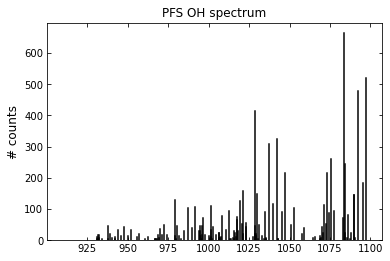

In [13]:
PFS_wavelengths, PFS_line_count = line_under_bandpass (PFS = True,verbose=False)
plot_utils.plot_line(PFS_wavelengths,PFS_line_count,'black')
plt.ylabel('# counts',fontsize = 12)
plt.title('PFS OH spectrum');

In [14]:
s = Sky.OHlines()
line_wlen,line_int,l =Sky.OHlines().load_skyline()
g,group_dir = Sky.OHlines().get_grouping(l)
wlen,inten,_ = s.get_line()

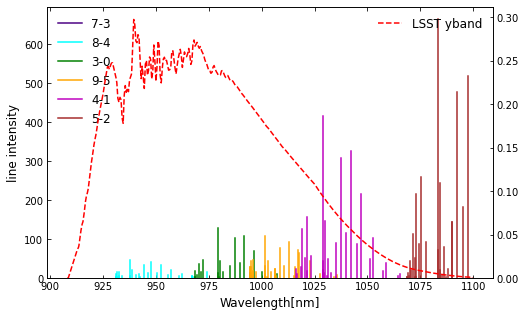

In [17]:
def OH_group_line (group_id,conv = True, verbose = False):
    
    if conv == True:
        line_wlen,line_int,l =Sky_rubin.OHlines().load_skyline()
        _,group_dir = Sky_rubin.OHlines().get_grouping(l)
        wlen,inten,_ = s.get_line()
        mask = (line_wlen > 908) & (line_wlen < 1099)
        group_count = PFS_line_count[group_dir[group_id][mask]]
        group_wlen =PFS_wavelengths[group_dir[group_id][mask]]
        return(group_wlen,group_count)
    else:
        wlen,inten,_ = s.get_line()
        return(wlen[group_id],inten[group_id])
f,ax = plt.subplots(1,1,figsize = (8,5))
colors = ['indigo','aqua','green','orange','m','brown','black']
for c,name in zip(colors[:-1],s.vib_group[:-1]):
    a,b = OH_group_line(name)
    for i in range(len(a)):
        if i == 0:
            ax.plot([a[i],a[i]],[0,b[i]],color = c,label = name)

        ax.plot([a[i],a[i]],[0,b[i]],color = c)

ax.legend(frameon = False,loc = 'best',fontsize= 12)
#plt.ylabel('# counts',fontsize = 12)
ax.set_ylabel('line intensity',fontsize = 12)
ax.set_xlabel('Wavelength[nm]',fontsize = 12)
ax.set_ylim(0,);
ax2 = ax.twinx()
ax2.plot(yband.wavelen[mm],yband_QE.sb[mm],label = 'LSST yband',ls = '--',color = 'red')
ax2.set_ylim(0,)
ax2.legend(frameon = False,loc = 'best',fontsize= 12)

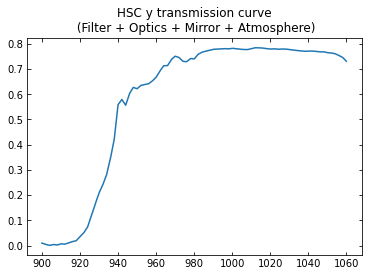

In [19]:
from scipy import interpolate
HSC_y_path = 'data/throughputs/HSC/y_HSC.txt'
HSC_qe_path = 'data/throughputs/HSC/qe_ccd_HSC.txt'
def load_txt(f_name):
    wlen = np.loadtxt(f_name,usecols=0)
    thr = np.loadtxt(f_name,usecols=1)
    
    return(wlen,thr)

HSC_y_wlen,HSC_y_thr  =load_txt(HSC_y_path)
HSC_qe_wlen,HSC_qe = load_txt(HSC_qe_path)

f_thr = interpolate.interp1d(HSC_y_wlen/10, HSC_y_thr)
f_qe = interpolate.interp1d(HSC_qe_wlen/10, HSC_qe,fill_value='extrapolate')
wavelen = np.arange(900,1060,0.1)

Paper Figure 8

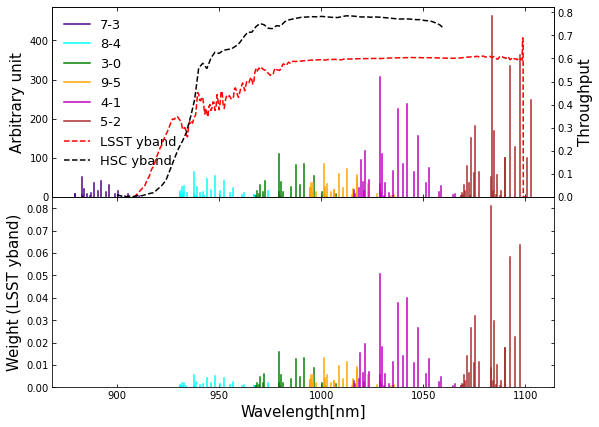

In [20]:
fig, ax = plt.subplots(nrows=2, figsize = (9,7),sharex=True)
plt.subplots_adjust(hspace=0,wspace=0)
ax2 = ax[0].twinx()
colors = ['indigo','aqua','green','orange','m','brown','black']


lns  = ax[0].plot()
for c,name in zip(colors[:-1],s.vib_group[:-1]):
    a,b = OH_group_line(name,conv=False)
    
    
    for i in range(len(a)):
        if i == 0:
            lns += ax[0].plot([a[i],a[i]],[0,b[i]],color = c,label = name)

        ax[0].plot([a[i],a[i]],[0,b[i]],color = c)
        
lns += ax2.plot(yband.wavelen[mm],yband.sb[mm],label = 'LSST yband',ls = '--',color = 'red')
lns += ax2.plot(wavelen,f_thr(wavelen)/f_qe(wavelen),ls = '--',label = 'HSC yband',color = 'black')
ax2.set_ylim(0,)
#ax2.legend(loc = 0)
ax2.set_ylabel('Throughput',fontsize = 15);


#ax[0].legend(frameon = False)
ax[0].set_ylabel('Arbitrary unit',fontsize = 15)
ax[0].set_xlabel('Wavelength[nm]',fontsize = 15)
ax[0].set_ylim(0,)

labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0,frameon = False,fontsize = 13)

for c,name in zip(colors[:-1],s.vib_group[:-1]):
    a,b = OH_group_line(name)

    for i in range(len(a)):
        if i == 0:
            ax[1].plot([a[i],a[i]],[0,b[i]/upper_count],color = c,label = name)

        ax[1].plot([a[i],a[i]],[0,b[i]/upper_count],color = c)
#ax[1].legend()
ax[1].set_ylabel('Weight (LSST yband)',fontsize = 15)
ax[1].set_xlabel('Wavelength[nm]',fontsize = 15)
ax[1].set_ylim(0,);

#fig.savefig('Paperplots/OH_spec2.eps')